In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import scipy.spatial
import sklearn.preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import keras

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences


**Consider only RAPID PRODUCTIVITY LOSS fault classification.**


In [2]:
EVENT = 5


In [3]:
#initialize the random state

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


**Code that reads the dataset 3W version 2. This is the code written by Afrânio (afrniomelo) in the same Kaggle´s dataset.** 


In [4]:
%%time

PATH = f'./3W/{EVENT}/'

files = [f for f in os.listdir(PATH) if os.path.isfile(os.path.join(PATH, f))]
files

dfs = {}


for file in files:
    dfs[file[:-4]] = pd.read_csv(f'{PATH}{file}', index_col = 0,
                     parse_dates = True).rename_axis(None)

wells_numbers = []
    
for key in dfs.keys():
    if 'SIMULATED' in key or 'DRAWN' in key:
        continue
    else:
        wells_numbers.append(int(key[8:10]))
        
print('Data read!\nNumber of instances: ',len(dfs))
print('Number of real instances: ',len(wells_numbers))


Data read!
Number of instances:  450
Number of real instances:  11
CPU times: total: 7.59 s
Wall time: 22.1 s



**Preprocessing simulated data.**


In [5]:
time_series = []

for key in dfs.keys():
  if 'SIMULATED' in key:
    df = dfs[key].copy()  
    df.bfill(axis = 0, inplace=True)
    df.ffill(axis = 0, inplace=True)
    df = df.iloc[::3]
    df.drop(['P-JUS-CKGL', 'T-JUS-CKGL', 'QGL' ], axis = 1, inplace = True ) 
    
    if 'class_5.0' in df.columns:
      df.rename(columns={'class_5.0': 'class_5'}, inplace=True)
    if 'class_0.0' in df.columns:
      df.rename(columns={'class_0.0': 'class_0'}, inplace=True)
    if 'class_105.0' in df.columns:
      df.rename(columns={'class_105.0': 'class_105'}, inplace=True)
    
    if 5 not in df['class'].values:
      df['class_5'] = False
    if 0 not in df['class'].values:
      df['class_0'] = False
    if 105 not in df['class'].values:
      df['class_105'] = False
        
    df = pd.get_dummies(df, columns=['class'], dummy_na = False)
    time_series.append(df)  


**Preprocessing Real Data.** 


In [6]:
time_series2 = []


for key in dfs.keys():
  if ('WELL' in key):
     
    df = dfs[key].copy()
    df = df.dropna(subset = ['class'])
    df.bfill(axis = 0, inplace=True)
    df.ffill(axis = 0, inplace=True)    
    df = df.iloc[::3]
    df.drop(['P-JUS-CKGL', 'T-JUS-CKGL', 'QGL' ], axis = 1, inplace = True ) 
        
    if 'class_5.0' in df.columns:
      df.rename(columns={'class_5.0': 'class_5'}, inplace=True)
    if 'class_0.0' in df.columns:
      df.rename(columns={'class_0.0': 'class_0'}, inplace=True)
    if 'class_105.0' in df.columns:
      df.rename(columns={'class_105.0': 'class_105'}, inplace=True)
    
    
    if 5 not in df['class'].values:
      df['class_5'] = False
    if 0 not in df['class'].values:
      df['class_0'] = False
    if 105 not in df['class'].values:
      df['class_105'] = False
            
    df = pd.get_dummies(df, columns=['class'], dummy_na = False)

    #check if there is any nan
    is_there_nan = df.isna().any().any()
    print(is_there_nan)
    time_series2.append(df)  


False
False
False
False
False
False
False
False
False
False
False


In [7]:
def get_label(df):
    if  (('class_0' in df ) and df['class_0'].all()) or (('class_0.0' in df ) and df['class_0.0'].all()):
       return 0
    else:
       return 1
    


**Auxiliar function that creates slider windows. The parameters "ncop1" and "ncop2" are used to balance the fault and non fault number of instances.**


In [8]:
def generate_instantes_from_dataframe(list_var, list_label, time_serie, window_length, 
                                      sample_period1, sample_period2, k, ncop1, ncop2 ) :
   
     i = 0
     while (i + window_length) < time_serie.shape[0]:
        var = time_serie.iloc[ i: i + window_length, 0:5] 
        label = get_label(time_serie.iloc[ i: i + window_length ]) 
          
        if label == 1:
           k[1] += 1
           i += sample_period1
           for aux in range(ncop2):  
              list_label.append(label)
              list_var.append(var)  
        else: 
           k[0] += 1
           i += sample_period2 
           for aux in range(ncop1):  
              list_label.append(label)
              list_var.append(var)
            


**Creates the slider windows made by real data.**


In [9]:
k = [0,0]
window_length = 120

instances_var = []
instances_label = []

k = [0,0]
for j in range(0,8):
   df = time_series2[j]  # time_series2 is the real data
   print(j)
   print(df.columns)
   generate_instantes_from_dataframe(instances_var, instances_label, df, window_length, 
                                     1, 1, k, 4, 1 )
   print( k )

0
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0.0',
       'class_5.0', 'class_105.0'],
      dtype='object')
[15165, 2986]
1
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0.0',
       'class_5.0', 'class_105.0'],
      dtype='object')
[15639, 3689]
2
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_5',
       'class_0.0', 'class_105.0'],
      dtype='object')
[15688, 4056]
3
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0.0',
       'class_5.0', 'class_105.0'],
      dtype='object')
[15695, 4987]
4
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0.0',
       'class_5.0', 'class_105.0'],
      dtype='object')
[16021, 8473]
5
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0.0',
       'class_5.0', 'class_105.0'],
      dtype='object')
[17119, 54591]
6
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0.0',
       'class_5.0', 'class_105.0'],
      dt

In [10]:
X = np.array(instances_var)
del instances_var
Y = np.array(instances_label)
del instances_label


**Shuffle the slider windows.**


In [11]:
indices = np.random.permutation(X.shape[0])
X_shuffled = X[indices]
del X
Y_shuffled = Y[indices]
del Y

In [12]:
X_shuffled.shape

(162554, 120, 5)

In [13]:
Y_shuffled.shape

(162554,)


**Split the data into training and testing.**


In [14]:
train_size = int(len(X_shuffled) * 0.8)
X_train, X_test = X_shuffled[:train_size], X_shuffled[train_size:]
del X_shuffled
y_train, y_test = Y_shuffled[:train_size], Y_shuffled[train_size:]
del Y_shuffled

In [15]:
X_train.shape


(130043, 120, 5)

In [16]:
np.any(np.isnan(X_test))

False

**Defining the model.**

In [17]:
from keras.regularizers import l2

model = keras.models.Sequential()
model.add( keras.layers.InputLayer( input_shape=[None,5]))
for rate in (1, 2, 4, 8, 16 ) * 2:
    model.add(keras.layers.Conv1D(filters=rate,
                     kernel_size=2,
                     padding="causal",
                     activation="elu",
                     dilation_rate=rate ))  
    model.add(keras.layers.BatchNormalization())

model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(1, activation="sigmoid"))

In [18]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min',          
    verbose=1           
)

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

**Training the model using the real data.**

In [20]:
history = model.fit(X_train, y_train, 
                   epochs=10, verbose=1, batch_size=2048,
                validation_split=0.2, callbacks=[checkpoint]  ) 


Epoch 1/10
51/51 [==============================] - ETA: 0s - loss: 0.5430 - accuracy: 0.7245
Epoch 1: val_loss improved from inf to 0.62498, saving model to best_model.keras
51/51 [==============================] - 17s 292ms/step - loss: 0.5430 - accuracy: 0.7245 - val_loss: 0.6250 - val_accuracy: 0.5230
Epoch 2/10
51/51 [==============================] - ETA: 0s - loss: 0.4083 - accuracy: 0.8375
Epoch 2: val_loss improved from 0.62498 to 0.57989, saving model to best_model.keras
51/51 [==============================] - 14s 283ms/step - loss: 0.4083 - accuracy: 0.8375 - val_loss: 0.5799 - val_accuracy: 0.5230
Epoch 3/10
51/51 [==============================] - ETA: 0s - loss: 0.4076 - accuracy: 0.8375
Epoch 3: val_loss improved from 0.57989 to 0.50904, saving model to best_model.keras
51/51 [==============================] - 16s 312ms/step - loss: 0.4076 - accuracy: 0.8375 - val_loss: 0.5090 - val_accuracy: 0.8334
Epoch 4/10
51/51 [==============================] - ETA: 0s - loss: 0.4


**Test the model with real data.**


In [21]:
model = keras.models.load_model('best_model.keras')

loss, accuracy = model.evaluate(X_test, y_test)

print(f'Accuracy in the test set: {accuracy:.2f}')

1016/1016 [==============================] - 3s 2ms/step - loss: 0.4076 - accuracy: 0.8387
Accuracy in the test set: 0.84



**Get metrics.**


In [22]:
import tensorflow as tf

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
f1 = tf.keras.metrics.Mean(name='f1_score')

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

precision.update_state(y_test, y_pred_classes)
recall.update_state(y_test, y_pred_classes)

precision_value = precision.result().numpy()
recall_value = recall.result().numpy()
f1_value = 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-10)

print(f'Precision: {precision_value:.2f}, Recall: {recall_value:.2f}, F1 Score: {f1_value:.2f}')

1016/1016 [==============================] - 3s 2ms/step
Precision: 0.76, Recall: 0.96, F1 Score: 0.85


**Display the Confusion Matrix related to the process of training and testing with real data. The value 0 corresponds to an absense of problems, and the value 1 corresponds to a fault in the oil well.**

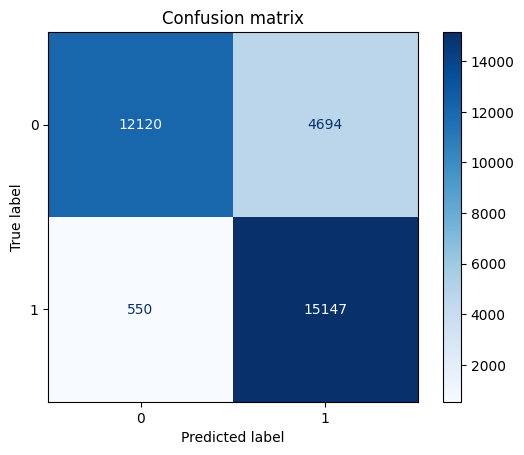

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

cm = confusion_matrix(y_test, y_pred_classes.flatten())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion matrix')
plt.savefig('confusion_matrix1.png', dpi = 300)
#plt.show()


**Select slider windows from a subset of the simulated dataset.**
**We are just using 20 time series.**


In [24]:
k = [0,0]
window_length = 120

instances_var_simul = []
instances_label_simul = []

for j in range(20):
   df = time_series[j]
   print(j)
   print(df.columns)
   generate_instantes_from_dataframe(instances_var_simul, instances_label_simul, df, window_length, 
                                     1, 1, k, 192, 1 )
    
   print( k )


0
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0',
       'class_5', 'class_105'],
      dtype='object')
[48, 9599]
1
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0',
       'class_5', 'class_105'],
      dtype='object')
[96, 19198]
2
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0',
       'class_5', 'class_105'],
      dtype='object')
[144, 28797]
3
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0',
       'class_5', 'class_105'],
      dtype='object')
[192, 38396]
4
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0',
       'class_5', 'class_105'],
      dtype='object')
[240, 47995]
5
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0',
       'class_5', 'class_105'],
      dtype='object')
[288, 57594]
6
Index(['P-PDG', 'P-TPT', 'T-TPT', 'P-MON-CKP', 'T-JUS-CKP', 'class_0',
       'class_5', 'class_105'],
      dtype='object')
[336, 67193]
7
Index(['P-PDG', 'P-TP

In [25]:
X_simul = np.array(instances_var_simul)
Y_simul = np.array(instances_label_simul)


**Shuffle the data.** 


In [26]:
indices = np.random.permutation(X_simul.shape[0])
X_simul_shuffled = X_simul[indices]
del X_simul
Y_simul_shuffled = Y_simul[indices]
del Y_simul

In [27]:
X_simul_shuffled.shape

(376300, 120, 5)

In [28]:
Y_simul_shuffled.shape

(376300,)


**Splitting the simulated data into training and testing.**


In [29]:
train_simul_size = int(len(X_simul_shuffled) * 0.8)
X_train_simul, X_test_simul = X_simul_shuffled[:train_simul_size], X_simul_shuffled[train_simul_size:]
del X_simul_shuffled
y_train_simul, y_test_simul = Y_simul_shuffled[:train_simul_size], Y_simul_shuffled[train_simul_size:]
del Y_simul_shuffled

In [30]:
X_train_simul.shape

(301040, 120, 5)

In [31]:
np.any(np.isnan(X_test_simul))


False

In [32]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_simul_model.keras',  
    monitor='val_loss', 
    save_best_only=True,  
    mode='min',           
    verbose=1           
)


**Training the model with simulated data.**


In [33]:
history = model.fit(X_train_simul, y_train_simul, 
                   epochs=30, verbose=1, batch_size=2048,
                   validation_split=0.2, callbacks=[checkpoint]  ) 

Epoch 1/30
118/118 [==============================] - ETA: 0s - loss: 0.3172 - accuracy: 0.8769
Epoch 1: val_loss improved from inf to 1.36113, saving model to best_simul_model.keras
118/118 [==============================] - 61s 503ms/step - loss: 0.3172 - accuracy: 0.8769 - val_loss: 1.3611 - val_accuracy: 0.5094
Epoch 2/30
118/118 [==============================] - ETA: 0s - loss: 0.2820 - accuracy: 0.8778
Epoch 2: val_loss improved from 1.36113 to 0.83719, saving model to best_simul_model.keras
118/118 [==============================] - 66s 562ms/step - loss: 0.2820 - accuracy: 0.8778 - val_loss: 0.8372 - val_accuracy: 0.4906
Epoch 3/30
118/118 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.8920
Epoch 3: val_loss did not improve from 0.83719
118/118 [==============================] - 67s 572ms/step - loss: 0.2495 - accuracy: 0.8920 - val_loss: 3.5705 - val_accuracy: 0.5094
Epoch 4/30
118/118 [==============================] - ETA: 0s - loss: 0.2133 - accura


**Get the accuracy in the simulated test set.**


In [34]:
model = keras.models.load_model('best_simul_model.keras')
loss, accuracy = model.evaluate(X_test_simul, y_test_simul)
print(f'Accuracy in the simulated test set: {accuracy:.2f}')

2352/2352 [==============================] - 10s 4ms/step - loss: 0.1634 - accuracy: 0.9266
Accuracy in the simulated test set: 0.93



**Get the metrics using simulated training and test data.**


In [36]:
import tensorflow as tf

precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
f1 = tf.keras.metrics.Mean(name='f1_score')

y_pred_simul = model.predict(X_test_simul)
y_pred_simul_classes = (y_pred_simul > 0.5).astype(int)

precision.update_state(y_test_simul, y_pred_simul_classes)
recall.update_state(y_test_simul, y_pred_simul_classes)

precision_value = precision.result().numpy()
recall_value = recall.result().numpy()
f1_score = 2 * (precision_value * recall_value) / (precision_value + recall_value + 1e-10)

print(f'Precision: {precision_value:.2f}, Recall: {recall_value:.2f}, F1 Score: {f1_score:.2f}')

2352/2352 [==============================] - 9s 4ms/step
Precision: 0.95, Recall: 0.90, F1 Score: 0.93



**Display the confusion matrix related to the process of training with simulated data and testing with simulated data. The value 0 corresponds to the absense of problems, and the value 1 corresponds to a fault in the oil well.**


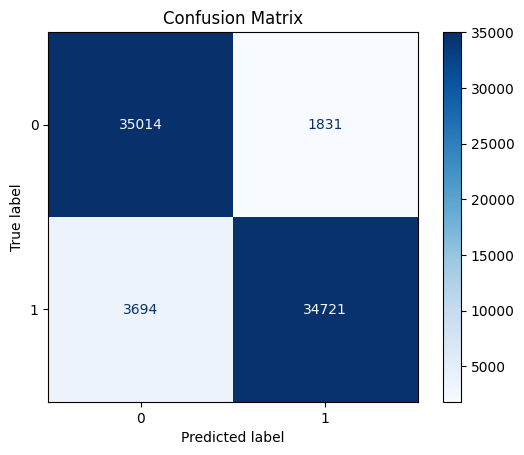

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

cm = confusion_matrix(y_test_simul, y_pred_simul_classes.flatten())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix2.png', dpi = 300)
plt.show()


**Get the accuracy of training using simulated data and testing in real data. The accuracy of 52% is a strong indicator 
that there are patterns preset in real signals that are not present in the simulated one.**


In [38]:
model = keras.models.load_model('best_simul_model.keras')

loss, accuracy = model.evaluate(X_test, y_test)

print(f'Accuracy using the model trained with real data and tested in real one: {accuracy:.2f}')

1016/1016 [==============================] - 5s 4ms/step - loss: 9.7543 - accuracy: 0.5172
Accuracy using the model trained with real data and tested in real one: 0.52



**Display the confusion matrix related to the process of trainig with simulated data and testing with real one. The value 0 corresponds to the absense of problems, and the value 1 corresponds to a fault in the oil well. In this case, the model has not identified any fault.**


1016/1016 [==============================] - 4s 4ms/step


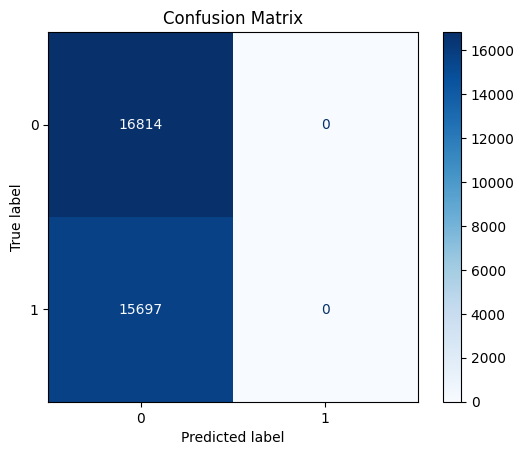

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_classes.flatten())

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix3.png', dpi = 300)
plt.show()